In [1]:
#General exclusion criteria - accuracy? 

In [1]:
import sys, os
#os.chdir('C:\\Users\\Steffi\\Desktop\\PSR\\Analysis')
sys.path.append(os.getcwd()+'/PyGazeAnalyser/')
import pygazeanalyser
from pygazeanalyser.edfreader import read_edf
# append Pygaz analyser folder, cloned from https://github.com/esdalmaijer/PyGazeAnalyser.git

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
%matplotlib inline

from statistics import mean
from scipy.stats import pearsonr, spearmanr, kstest


In [2]:
#without sub that has 38% missed trials in crowding (13), and subs with chance level accuracy in crowding (3,10,14)
# and sub with <85% accuracy in visual search task (8)
subjects = ['01','02','04','05','07','09','11','12','16']
#without sub that has 38% missed trials in crowding (13), and subs with chance level accuracy in crowding (3,10,14)
#['01','02','04','05','07','08','09','11','12','16']
#without sub that has 38% missed trials in crowding
#['01','02','03','04','05','07','08','09','10','11','12','14','16'] 
# "all" subjects
#['01','02','03','04','05','07','08','09','10','11','12','13','14','16']

## Crowding Task

In [3]:
# Params
total_trials = 720
blocks = 5 #including one practice block
trials_block = total_trials/blocks
trials = total_trials - trials_block #number of trials excluding training
ecc = [4,8,12]
last_trials = 96 #number of trials to calculate critical distance

crowding_files = []
for sub in range(len(subjects)):
    filename = os.path.join(os.getcwd(),'Data/output_crowding/data_crowding_pp_%s.csv' %(subjects[sub]))
    #filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_crowding\\data_crowding_pp_%s.csv' %(subjects[sub])
    crowding_files.append(filename)

**Missed trials**

In [4]:
missed_trials = np.zeros(len(subjects))

for sub in range(len(subjects)):
    
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    miss = []
    
    #for trial in range(int(trials_block),int(total_trials)):
    #    
    #    if data_sub['key_pressed'][trial] != "right" and data_sub['key_pressed'][trial] != "left":
    #        miss.append(1)
    miss = data_sub['key_pressed'].isna().sum() #easier way to count NaNs in dataframe
            
    missed_trials[sub] = miss/len(data_sub)#len(miss)/len(data_sub)

In [5]:
#print('Percentage of missed trials per participant')
print(missed_trials)

[ 0.07118056  0.02083333  0.04513889  0.00173611  0.          0.04861111
  0.03472222  0.13888889  0.01388889]


**Reaction times and TFR plots**

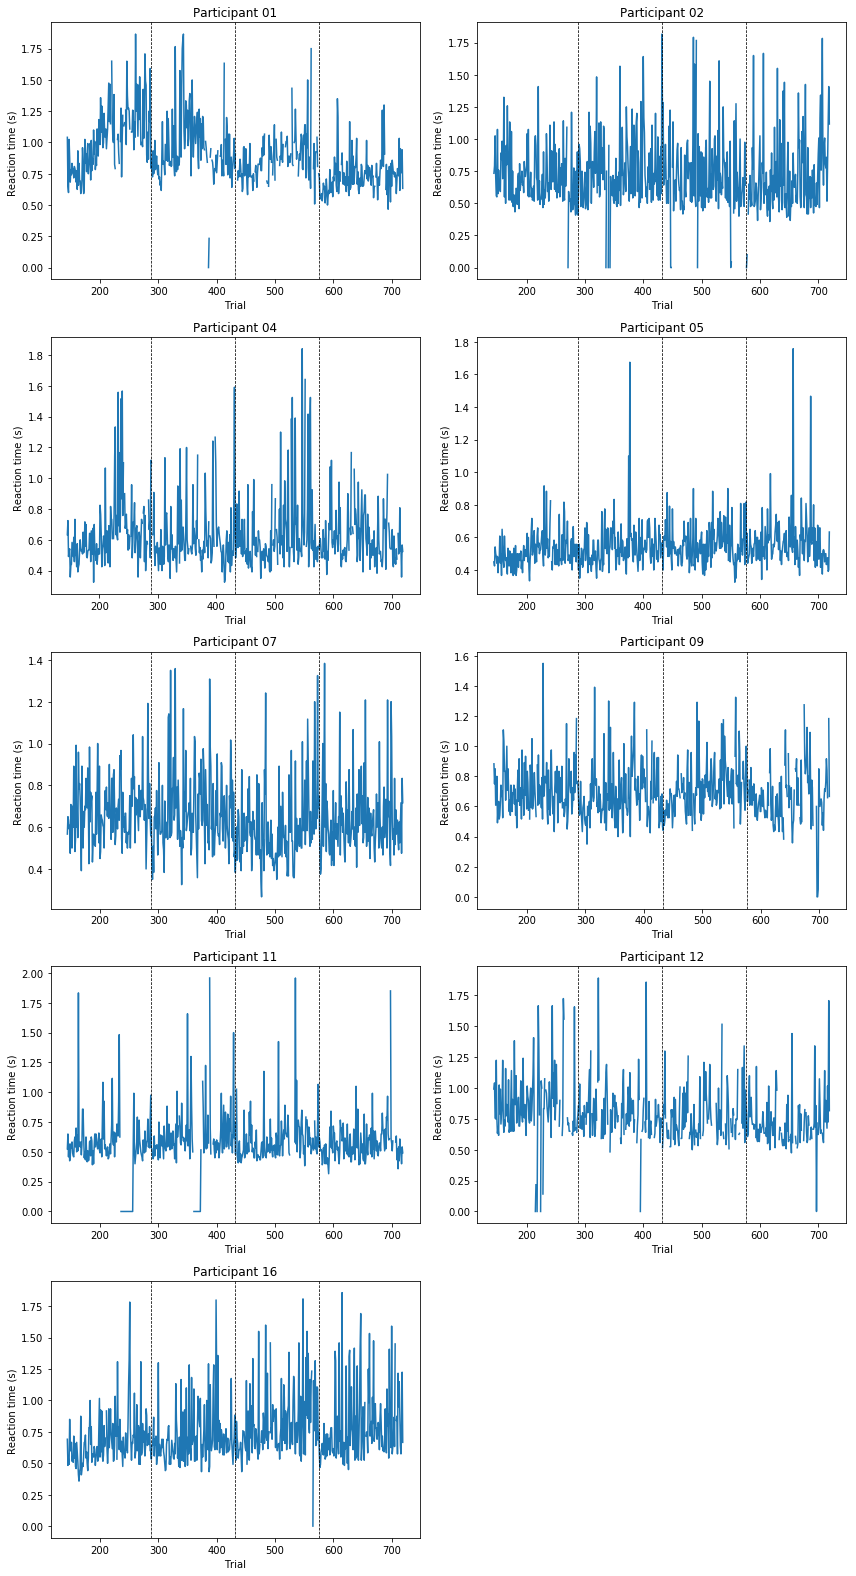

In [6]:
rows = (len(subjects)/2)+1
plt.figure(figsize=(12,rows*4))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    plt.subplot(rows,2,sub+1)
    plt.plot(data_sub["RT"])
    plt.ylabel("Reaction time (s) ")
    plt.xlabel("Trial")
    plt.title('Participant %s' %subjects[sub])
    xposition = [288,432,576]
    for xc in xposition:
        plt.axvline(x=xc, ls='--', c='k', lw=0.75)
plt.tight_layout()

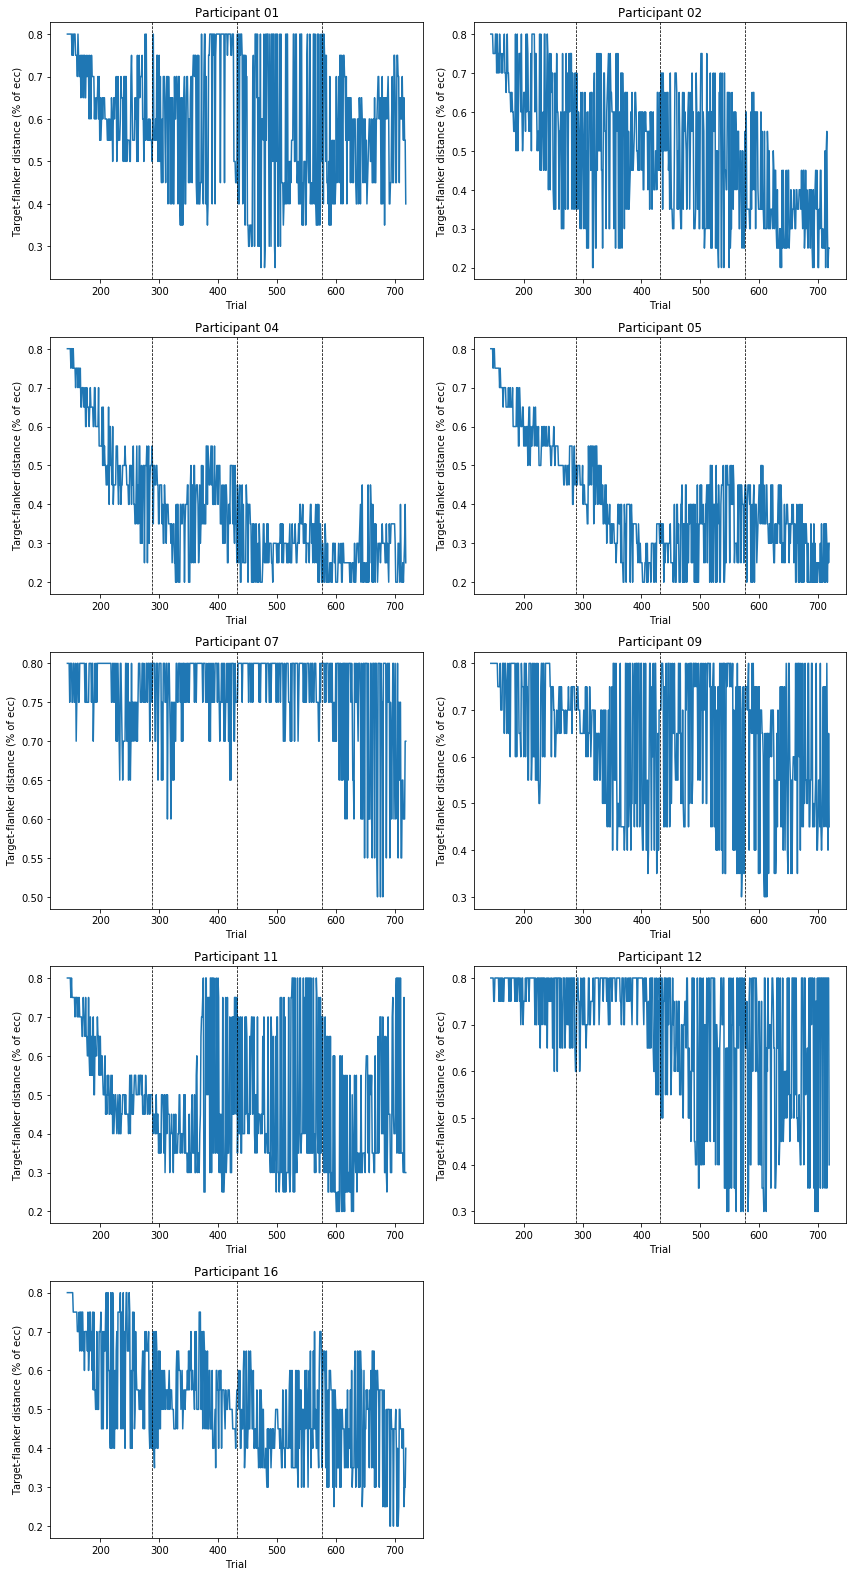

In [7]:
plt.figure(figsize=(12,rows*4))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    plt.subplot(rows,2,sub+1)
    plt.plot(data_sub["target_flank_ratio"])
    plt.ylabel("Target-flanker distance (% of ecc)")
    plt.xlabel("Trial")
    plt.title('Participant %s' %subjects[sub])
    xposition = [288,432,576]
    for xc in xposition:
        plt.axvline(x=xc, ls='--', c='k', lw=0.75)
plt.tight_layout()

**Accuracy Flankers vs. no Flankers**

In [8]:
# similar to what you had done before, just wrote this to check if it makes sense
for sub in range(len(subjects)):
    
    flank_ecc = np.zeros((len(ecc))) # (3,1) count num trials with flankers per ecc
    flank_corrTrial = np.zeros((len(ecc))) # (3,1) count num trials with flankers and correct response per ecc
    noflank_ecc = np.zeros((len(ecc))) # (3,1) count num trials without flankers per ecc
    noflank_corrTrial = np.zeros((len(ecc))) # (3,1) count num trials without flankers and correct response per ecc
   
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    
    for i in range(int(trials_block),int(total_trials)):
        
        val = data_sub['key_pressed'][i]
        if type(val) == float and np.isnan(val): #check is object is float and then if it's NaN = missed trials
            continue #print('response is NaN, missed trial %d'%i )
        
        else:#actual responses to calculate accuracy
            ecc_idx = ecc.index(int(data_sub["target_ecc"][i]))
            
            if data_sub["flanker_presence"][i]=="flankers": #flanker trial                
                flank_ecc[ecc_idx]+=1
                if data_sub['key_pressed'][i]==data_sub['target_orientation'][i]: #count correct responses
                    flank_corrTrial[ecc_idx]+=1
            else: # no flanker
                noflank_ecc[ecc_idx]+=1
                if data_sub['key_pressed'][i]==data_sub['target_orientation'][i]: #count correct responses
                    noflank_corrTrial[ecc_idx]+=1
                    
                    
    acc_flank = [flank_corrTrial[x]/flank_ecc[x] for x in range(len(ecc))]
    acc_ecc_flank = acc_flank if sub == 0 else np.vstack((acc_ecc_flank,acc_flank))
    
    acc_noflank = [noflank_corrTrial[x]/noflank_ecc[x] for x in range(len(ecc))]
    acc_ecc_noflank = acc_noflank if sub == 0 else np.vstack((acc_ecc_noflank,acc_noflank))
    

In [79]:
''''
trials_per_ecc = trials/len(ecc)
trials_per_ecc_flank = trials_per_ecc/1.2
trials_per_ecc_noflank = trials_per_ecc/6

acc_ecc_flank = np.zeros((len(subjects), len(ecc)))
acc_ecc_noflank = np.zeros((len(subjects), len(ecc)))

for sub in range(len(subjects)):
    
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    
    for e in range(len(ecc)):
        acc_flank = []
        trials_flank = []
        acc_noflank = []
        trials_noflank = []

        for i in range(int(trials_block),int(total_trials)):
            
            val = data_sub['key_pressed'][i]
            if type(val) == float and np.isnan(val): #check is object is float and then if it's NaN = missed trials
                continue #print('response is NaN, missed trial %d'%i )
            else: #actual responses to calculate accuracy
                if data_sub["flanker_presence"][i]=="flankers" and data_sub["target_ecc"][i]==ecc[e]:
                    trials_flank.append(True)
                    trials_noflank.append(False)

                    if data_sub['key_pressed'][i]==data_sub['target_orientation'][i]:
                        acc_flank.append(True)
                    else:
                        acc_flank.append(False)

                if data_sub['flanker_presence'][i]=="no flankers" and data_sub["target_ecc"][i]==ecc[e]:
                    trials_noflank.append(True)
                    trials_flank.append(False)
                
                    if data_sub['key_pressed'][i]==data_sub['target_orientation'][i]:
                        acc_noflank.append(True)
                    else:
                        acc_noflank.append(False)
       
        acc_ecc_flank[sub,e]=(sum(acc_flank)/sum(trials_flank))
        acc_ecc_noflank[sub,e]=(sum(acc_noflank)/sum(trials_noflank))

In [9]:
print("Accuracy with Flankers:")
print(acc_ecc_flank)
print("Accuracy without Flankers:")
print(acc_ecc_noflank)

Accuracy with Flankers:
[[ 0.84076433  0.80379747  0.81343284]
 [ 0.8164557   0.85350318  0.87820513]
 [ 0.87417219  0.9044586   0.86092715]
 [ 0.83647799  0.89375     0.8375    ]
 [ 0.76875     0.65        0.66875   ]
 [ 0.84076433  0.79746835  0.66447368]
 [ 0.83647799  0.83647799  0.82432432]
 [ 0.79245283  0.75949367  0.7037037 ]
 [ 0.84177215  0.825       0.83333333]]
Accuracy without Flankers:
[[ 0.97297297  0.88888889  0.77272727]
 [ 1.          0.93939394  0.96774194]
 [ 1.          0.96875     1.        ]
 [ 1.          0.9375      0.97058824]
 [ 0.92857143  0.69444444  0.6875    ]
 [ 1.          0.75862069  0.70833333]
 [ 0.92        0.97058824  0.96774194]
 [ 0.83333333  0.76666667  0.88235294]
 [ 1.          1.          0.91666667]]


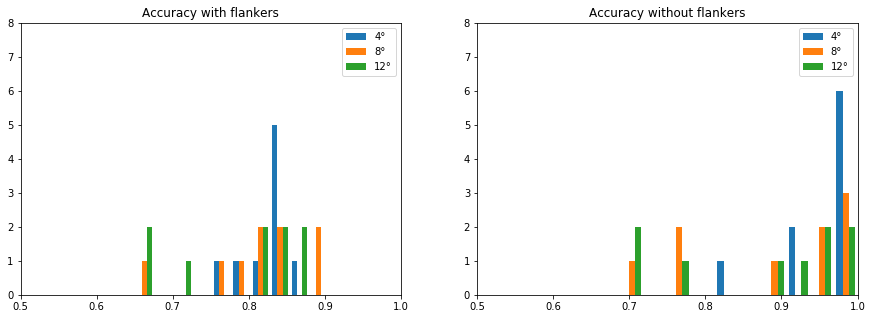

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(acc_ecc_flank)
plt.title('Accuracy with flankers')
plt.xlim(0.5,1.0)
plt.ylim(0,8)
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(acc_ecc_noflank)
plt.title('Accuracy without flankers')
plt.xlim(0.5,1.0)
plt.ylim(0,8)
plt.legend(['4°','8°','12°'])

**Calculate critical distance per participant**

In [13]:
crit_distance = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    #data_sub = data_sub.loc[(total_trials-last_trials):(total_trials-1)]
    
    for e in range(len(ecc)):
        
        tfr = []
        
        for i in range((total_trials-last_trials-1),(total_trials-1)):
            
            if data_sub["flanker_presence"][i]=="flankers" and data_sub["target_ecc"][i]==ecc[e]:
                tfr.append(data_sub["target_flank_ratio"][i])
    
        crit_distance[sub,e] = np.median(tfr) #sum(tfr)/len(tfr)

crit_dist_mean = np.median(crit_distance,axis=1) #np.mean(crit_distance,axis=1)     

In [14]:
print('Critical distance per participant and eccentricity')
print(crit_distance)
print('Critical distance per participant across eccentricities')
print(crit_dist_mean)

Critical distance per participant and eccentricity
[[ 0.45   0.6    0.65 ]
 [ 0.425  0.325  0.25 ]
 [ 0.3    0.2    0.35 ]
 [ 0.4    0.2    0.3  ]
 [ 0.6    0.8    0.8  ]
 [ 0.45   0.55   0.8  ]
 [ 0.35   0.35   0.65 ]
 [ 0.4    0.65   0.8  ]
 [ 0.3    0.575  0.45 ]]
Critical distance per participant across eccentricities
[ 0.6    0.325  0.3    0.3    0.8    0.55   0.35   0.65   0.45 ]


(0.2, 0.8)

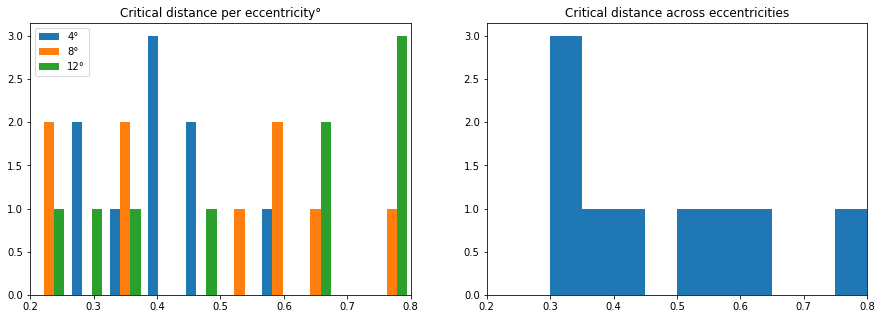

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(crit_distance)
plt.title('Critical distance per eccentricity°')
plt.xlim(0.2,0.8)
plt.legend(['4°','8°','12°'])

plt.subplot(1,2,2)
plt.hist(crit_dist_mean)
plt.title('Critical distance across eccentricities')
plt.xlim(0.2,0.8)

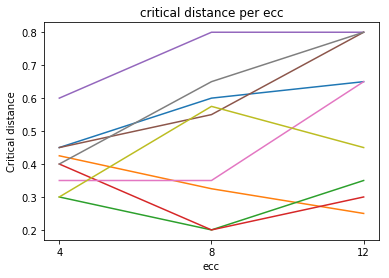

In [16]:
#plt.figure(figsize=(5,5))
%matplotlib inline
f, ax = plt.subplots()

for sub in range(len(subjects)):
    ax.plot(crit_distance[sub])

ax.set_xlabel('ecc')
ax.set_ylabel('Critical distance')
ax.set_title('critical distance per ecc')
ax.set_xticks([0,1,2])
ax.set_xticklabels(ecc)
plt.show()


**Test value distribution**

In [17]:
print('Mean across eccentricities')
print(kstest(crit_dist_mean, 'norm'))
print('Eccentricity 4°')
print(kstest(crit_distance[:,0], 'norm'))
print('Eccentricity 8°')
print(kstest(crit_distance[:,1], 'norm'))
print('Eccentricity 12°')
print(kstest(crit_distance[:,2], 'norm'))

Mean across eccentricities
KstestResult(statistic=0.61791142218895256, pvalue=0.00077149521246755448)
Eccentricity 4°
KstestResult(statistic=0.61791142218895256, pvalue=0.00077149521246755448)
Eccentricity 8°
KstestResult(statistic=0.57925970943910299, pvalue=0.0021494482951758265)
Eccentricity 12°
KstestResult(statistic=0.5987063256829237, pvalue=0.0012991254748186964)


## Search Task

In [18]:
search_files = []
for sub in range(len(subjects)):
    #filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_VS\\data_visualsearch_pp_%s.csv' %(subjects[sub])
    filename = os.path.join(os.getcwd(),'Data/output_VS/data_visualsearch_pp_%s.csv' %(subjects[sub]))
    search_files.append(filename)

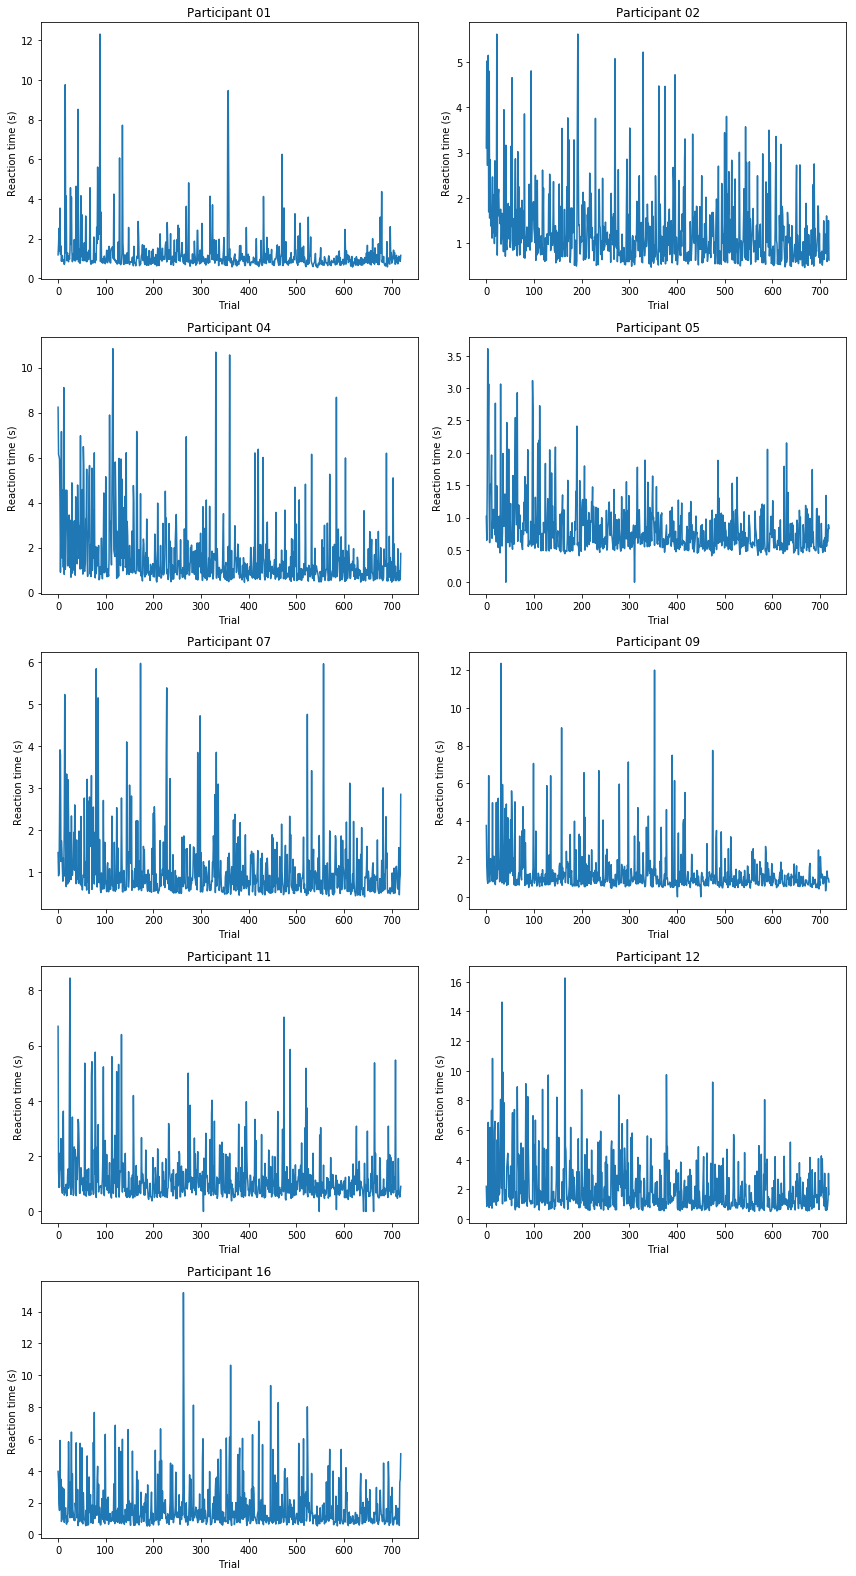

In [19]:
rows = (len(subjects)/2)+1
plt.figure(figsize=(12,rows*4))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(search_files[sub], sep='\t')
    plt.subplot(rows,2,sub+1)
    plt.plot(data_sub["RT"])
    plt.ylabel("Reaction time (s) ")
    plt.xlabel("Trial")
    plt.title('Participant %s' %subjects[sub])
   
plt.tight_layout()

In [20]:
trials = 720
blocks = 4 
trials_block = total_trials/blocks
ecc = [4,8,12]
set_size = [5,15,30]

In [21]:
rt_ecc = np.zeros((len(subjects),len(ecc)))
acc_ecc = np.zeros((len(subjects),len(ecc)))
rt_ecc_std = np.zeros((len(subjects),len(ecc)))
acc_ecc_std = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(search_files[sub], sep='\t')
    
    for e in range(len(ecc)):
        rts = []
        acc = []
        
        for n in range(len(data_sub)):
            if data_sub['target_ecc'][n]==ecc[e]:
                if data_sub['key_pressed'][n]== data_sub['target_orientation'][n]:
                    rts.append(data_sub["RT"][n])
                    acc.append(True)
                else:
                    acc.append(False)
        
        rt_ecc[sub,e]= np.mean(rts)#np.median(rts)
        acc_ecc[sub,e]= np.mean(acc) #np.median(acc)
        rt_ecc_std[sub,e]=np.std(rts)
        acc_ecc_std[sub,e]=np.std(acc)

rt_mean = np.mean(rt_ecc,axis=1) #np.median(rt_ecc,axis=1)
rt_std = np.std(rt_ecc, axis=1)
acc_mean = np.mean(acc_ecc, axis=1) #np.median(acc_ecc, axis=1)
acc_std = np.std(acc_ecc, axis=1)

**Reaction times**

In [22]:
print('Mean reaction times per participant and eccentricity')
print(rt_ecc)
print('Standard deviations')
print(rt_ecc_std)

Mean reaction times per participant and eccentricity
[[ 0.89947292  1.01737332  1.68079536]
 [ 0.94605388  1.14822061  1.6935956 ]
 [ 1.10006774  1.52876412  2.21923772]
 [ 0.58792084  0.75893011  1.09958611]
 [ 0.64536496  1.00813526  1.51736636]
 [ 0.93235339  1.13228997  1.75792353]
 [ 0.81745778  1.04108836  1.78317098]
 [ 1.28535008  2.01038016  2.97445669]
 [ 1.22703979  1.5818964   2.29152141]]
Standard deviations
[[ 0.45751121  0.49850341  1.4451504 ]
 [ 0.49204557  0.7156601   1.00116555]
 [ 0.99645742  1.45674208  1.73570029]
 [ 0.13192575  0.30386404  0.52561834]
 [ 0.27059836  0.63316323  0.92428871]
 [ 0.82385357  0.95580216  1.50872474]
 [ 0.52659536  0.71398374  1.27743307]
 [ 1.40141412  1.62481722  2.07315118]
 [ 1.01885248  1.43636396  1.81254562]]


In [23]:
print('Mean reaction times per participant across eccentricities')
print(rt_mean)
print('Standard deviations')
print(rt_std)

Mean reaction times per participant across eccentricities
[ 1.19921387  1.26262337  1.6160232   0.81547902  1.05695553  1.27418896
  1.21390571  2.09006231  1.70015253]
Standard deviations
[ 0.34391441  0.31572208  0.46104661  0.21267921  0.35766295  0.35165609
  0.41275487  0.69187293  0.44254466]


In [24]:
print('KS-Test for normality')
print('Mean across eccentricities')
print(kstest(rt_mean, 'norm'))
print('Eccentricity 4°')
print(kstest(rt_ecc[:,0], 'norm'))
print('Eccentricity 8°')
print(kstest(rt_ecc[:,1], 'norm'))
print('Eccentricity 12°')
print(kstest(rt_ecc[:,2], 'norm'))

KS-Test for normality
Mean across eccentricities
KstestResult(statistic=0.79260091487208983, pvalue=1.5254256466867844e-06)
Eccentricity 4°
KstestResult(statistic=0.72170728473576418, pvalue=2.8036859797575531e-05)
Eccentricity 8°
KstestResult(statistic=0.77605281651788605, pvalue=3.200681163884056e-06)
Eccentricity 12°
KstestResult(statistic=0.86424375143647492, pvalue=3.1325485094768624e-08)


**Accuracy**

In [25]:
print('Mean accuracy per participant and eccentricity')
print(acc_ecc)
print('Standard deviations')
print(acc_ecc_std)

Mean accuracy per participant and eccentricity
[[ 0.99583333  0.975       0.92916667]
 [ 1.          1.          1.        ]
 [ 1.          1.          0.99166667]
 [ 0.99583333  0.99583333  0.99166667]
 [ 0.99166667  0.99583333  0.99166667]
 [ 0.98333333  0.97916667  0.9875    ]
 [ 0.9875      0.9875      0.96666667]
 [ 0.9875      0.99166667  0.99166667]
 [ 1.          1.          1.        ]]
Standard deviations
[[ 0.0644151   0.15612495  0.25654624]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.09090593]
 [ 0.0644151   0.0644151   0.09090593]
 [ 0.09090593  0.0644151   0.09090593]
 [ 0.1280191   0.14282614  0.11110243]
 [ 0.11110243  0.11110243  0.17950549]
 [ 0.11110243  0.09090593  0.09090593]
 [ 0.          0.          0.        ]]


In [26]:
print('Mean accuracy per participant across eccentricities')
print(acc_mean)
print('Standard deviations')
print(acc_std)

Mean accuracy per participant across eccentricities
[ 0.96666667  1.          0.99722222  0.99444444  0.99305556  0.98333333
  0.98055556  0.99027778  1.        ]
Standard deviations
[ 0.02784714  0.          0.00392837  0.00196419  0.00196419  0.00340207
  0.00982093  0.00196419  0.        ]


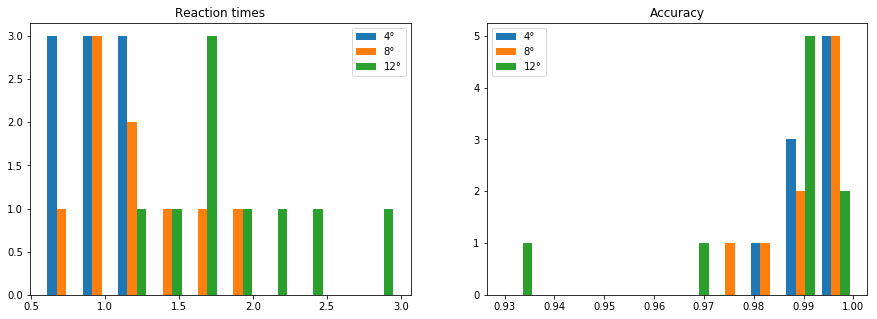

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(rt_ecc)
plt.title('Reaction times')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(acc_ecc)
plt.title('Accuracy')
plt.legend(['4°','8°','12°'])

**Reaction times as a function of set size**

In [28]:
rt_setsize = np.zeros((len(subjects),len(set_size)))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(search_files[sub], sep='\t')
    
    for s in range(len(set_size)):
        rts = []
        
        for n in range(len(data_sub)):
            if data_sub['set_size'][n]==set_size[s]:
                if data_sub['key_pressed'][n]== data_sub['target_orientation'][n]:
                    rts.append(data_sub["RT"][n])
        
        rt_setsize[sub,s]=np.mean(rts)
        
rt_setsize_mean = np.mean(rt_setsize,axis=0)

In [29]:
print('Reaction time per participant and set size')
print(rt_setsize)
print('Reaction time per set size across participants')
print(rt_setsize_mean)

Reaction time per participant and set size
[[ 0.9569795   1.18945436  1.42091652]
 [ 0.94894221  1.33590689  1.503021  ]
 [ 0.9691441   1.80872997  2.06677462]
 [ 0.70020139  0.80982359  0.93572647]
 [ 0.81634816  1.10869718  1.24360353]
 [ 0.8982768   1.40221616  1.52739066]
 [ 0.93236508  1.3219897   1.3762176 ]
 [ 1.33732001  2.04274154  2.88737978]
 [ 1.0770827   1.73321588  2.29015902]]
Reaction time per set size across participants
[ 0.95962888  1.41697503  1.69457658]


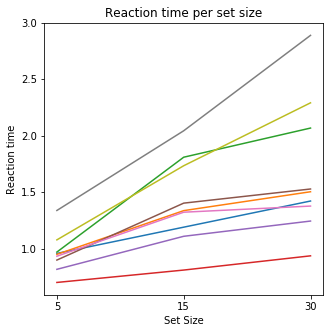

In [31]:
#plt.figure(figsize=(5,5))
f, ax = plt.subplots(figsize=(5,5))

for sub in range(len(subjects)):
    ax.plot(rt_setsize[sub])

ax.set_xlabel('Set Size')
ax.set_ylabel('Reaction time')
ax.set_title('Reaction time per set size')
ax.set_xticks([0,1,2])
ax.set_xticklabels(set_size)


## Eyedata

In [32]:
def ang2pix(dist_in_deg,h,d,r): 
    import math 
    
    deg_per_px = math.degrees(math.atan2(0.5*h,d))/(0.5*r)
    dist_in_px = dist_in_deg/deg_per_px
    return dist_in_px 

In [33]:
# paths
#os.chdir(r"C:\Users\Steffi\Desktop\PSR\Data")
base_dir = os.getcwd()
output_vs = os.path.join(base_dir,'Data','output_VS')#os.path.join(base_dir,'output_VS')
output_crwd = os.path.join(base_dir,'Data','output_crowding')#os.path.join(base_dir,'output_crowding')

In [34]:
# params 
vRes = 1050
hRes = 1680
ecc = [4,8,12]

gabor_size_deg = 2.2/2 #divide by 2 to get the radius
screen_distance = 50
screen_height = 30

gabor_size_pix = ang2pix(gabor_size_deg,screen_height,screen_distance,vRes) #radius in pixels

In [35]:
gabor_size_pix

34.58240336556183

In [36]:
eye_search_files = []
for sub in range(len(subjects)):
    filename = os.path.join(output_vs,'pp-%s'%subjects[sub],'eyedata_visualsearch_pp_%s.asc' %subjects[sub])
    #filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_VS\\pp-%s\\eyedata_visualsearch_pp_%s.asc' %(subjects[sub],subjects[sub])
    eye_search_files.append(filename)

In [37]:
eye_crowd_files = []
for sub in range(len(subjects)):
    filename = os.path.join(output_crwd,'pp-%s'%subjects[sub],'eyedata_crowding_pp_%s.asc' %subjects[sub])
    #filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_crowding\\pp-%s\\eyedata_crowding_pp_%s.asc' %(subjects[sub],subjects[sub])
    eye_crowd_files.append(filename)

**Gaze control crowding task**

In [38]:
fixpos = np.array(((hRes/2),(vRes/2)))
print('Coordinates of fixation:',fixpos)

gaze = np.zeros(len(subjects))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_crowd_files[sub], 'start_trial', stop='stop_trial', debug=False)
    
    deviation = []
    
    for trial in range(len(eye_data)):
        x = eye_data[trial]['x']
        y = eye_data[trial]['y']
        eye_pos = np.array((x,y)).T
        #print(eye_pos)
        for pos in range(len(eye_pos)):
            distance = np.sqrt(np.sum((fixpos-eye_pos[pos])**2))
            #print(distance)
            deviation.append(distance)
            
    gaze[sub]=np.median(deviation)#np.mean(deviation)

Coordinates of fixation: [ 840.  525.]


In [39]:
print('Mean deviation from fixation per participant')
print(gaze)

Mean deviation from fixation per participant
[ 23.00978053  70.48985743  18.02775638  32.67736219  15.62625995
  21.96588264  20.28718808  29.00827468  24.01416249]


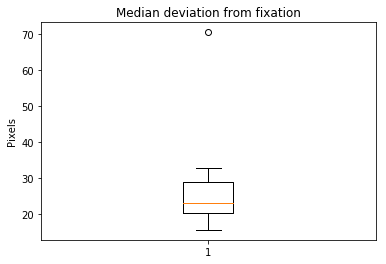

In [40]:
plt.boxplot(gaze)
plt.title('Median deviation from fixation')
plt.ylabel('Pixels')

**Number of fixations**

In [41]:
ecc_fix = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        num_fix = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e]:
                num_fix.append(len(eye_data[trial]['events']['Efix']))
    
        ecc_fix[sub,e] = np.mean(num_fix)

mean_fix = np.mean(ecc_fix,axis=1)

In [42]:
print('Mean number of fixations per subject and eccentricity')
print(ecc_fix)
print('Mean number of fixations per subject across eccentricities')
print(mean_fix)

Mean number of fixations per subject and eccentricity
[[  2.625        3.25         5.82083333]
 [  2.5625       3.3          5.4125    ]
 [  3.10833333   4.9125       7.85416667]
 [  2.43333333   3.30416667   5.0125    ]
 [  1.89166667   3.21666667   5.24583333]
 [  2.94166667   3.8          6.35      ]
 [  3.09166667   3.97083333   6.8       ]
 [  3.63333333   6.25        10.46666667]
 [  3.44583333   4.7375       7.29583333]]
Mean number of fixations per subject across eccentricities
[ 3.89861111  3.75833333  5.29166667  3.58333333  3.45138889  4.36388889
  4.62083333  6.78333333  5.15972222]


In [43]:
print('KS-Test for normality')
print('Mean across eccentricities')
print(kstest(mean_fix, 'norm'))
print('Eccentricity 4°')
print(kstest(ecc_fix[:,0], 'norm'))
print('Eccentricity 8°')
print(kstest(ecc_fix[:,1], 'norm'))
print('Eccentricity 12°')
print(kstest(ecc_fix[:,2], 'norm'))

KS-Test for normality
Mean across eccentricities
KstestResult(statistic=0.99972114533065959, pvalue=0.0)
Eccentricity 4°
KstestResult(statistic=0.97073229637340186, pvalue=3.1530333899354446e-14)
Eccentricity 8°
KstestResult(statistic=0.99935155409195331, pvalue=0.0)
Eccentricity 12°
KstestResult(statistic=0.9999997313631227, pvalue=0.0)


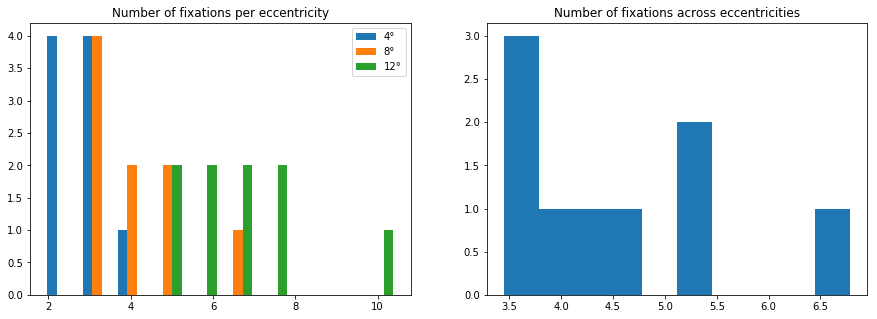

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ecc_fix)
plt.title('Number of fixations per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_fix)
plt.title('Number of fixations across eccentricities')

**Latency for leaving fixation**

In [45]:
#Using the duration of the first fixation - seems quite long though?
ecc_lat = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        lat = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Efix']==[]:
                
                lat.append(eye_data[trial]['events']['Efix'][0][2])
    
        ecc_lat[sub,e] = np.mean(lat)

mean_lat = np.mean(ecc_lat,axis=1)

In [46]:
print('Mean latency for leaving fixation per subject and eccentricity')
print(ecc_lat)
print('Mean latency for leaving fixation per subject across eccentricities')
print(mean_lat)

Mean latency for leaving fixation per subject and eccentricity
[[ 517.05416667  530.49367089  532.65690377]
 [ 545.84166667  539.2625      553.17916667]
 [ 421.275       431.38333333  411.43333333]
 [ 498.35744681  499.22317597  493.66244726]
 [ 474.1125      478.70833333  495.12970711]
 [ 471.32916667  489.1092437   488.0125    ]
 [ 394.09243697  393.07983193  390.88655462]
 [ 577.43162393  578.67916667  576.69583333]
 [ 519.55230126  527.7375      507.61666667]]
Mean latency for leaving fixation per subject across eccentricities
[ 526.73491377  546.09444444  421.36388889  497.08102334  482.65018015
  482.81697012  392.68627451  577.60220798  518.30215597]


In [47]:
#print('KS-Test for normality')
#print('Mean across eccentricities')
#print(kstest(mean_lat, 'norm'))
#print('Eccentricity 4°')
#print(kstest(ecc_lat[:,0], 'norm'))
#print('Eccentricity 8°')
#print(kstest(ecc_lat[:,1], 'norm'))
#print('Eccentricity 12°')
#print(kstest(ecc_lat[:,2], 'norm'))

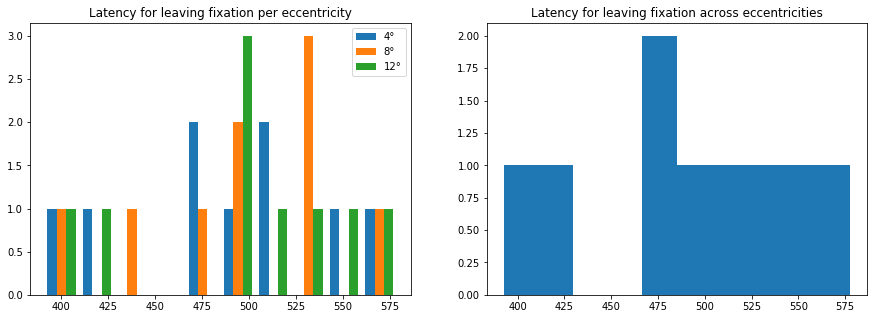

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ecc_lat)
plt.title('Latency for leaving fixation per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_lat)
plt.title('Latency for leaving fixation across eccentricities')

In [49]:
## decided to try and compute saccade latency
# (the time from the presentation of the target to the commencement of the saccade)
# in this case it's from moment where display was shown (eye_data[0]['events']['msg'] [-3][0]
# until the start of first saccade

ecc_sacclat = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        lat = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Ssac']==[]:
                
                lat.append(eye_data[trial]['events']['Ssac'][0]-eye_data[trial]['events']['msg'][-3][0])
    
        ecc_sacclat[sub,e] = np.median(lat)#np.mean(lat)

mean_sacclat = np.median(ecc_sacclat,axis=1)#np.mean(ecc_sacclat,axis=1)


In [50]:
print('Median saccadic latency per subject and eccentricity')
print(ecc_sacclat)
print('Median saccadic latency per subject across eccentricities')
print(mean_sacclat)

Median saccadic latency per subject and eccentricity
[[ 228.   244.   231. ]
 [ 250.5  246.   253. ]
 [ 176.   184.   180. ]
 [ 216.   224.   218. ]
 [ 189.5  194.5  200. ]
 [ 196.5  202.5  203.5]
 [ 177.5  180.   176. ]
 [ 260.   254.   250.5]
 [ 248.   246.5  248. ]]
Median saccadic latency per subject across eccentricities
[ 231.   250.5  180.   218.   194.5  202.5  177.5  254.   248. ]


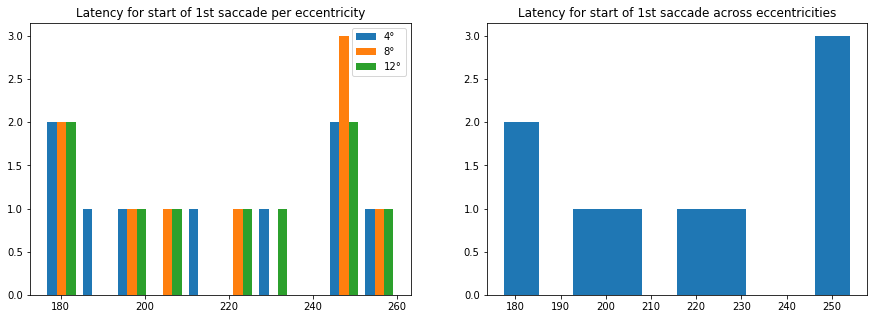

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ecc_sacclat)
plt.title('Latency for start of 1st saccade per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_sacclat)
plt.title('Latency for start of 1st saccade across eccentricities')

In [52]:
print('KS-Test for normality')
print('Mean across eccentricities')
print(kstest(mean_sacclat, 'norm'))
print('Eccentricity 4°')
print(kstest(ecc_sacclat[:,0], 'norm'))
print('Eccentricity 8°')
print(kstest(ecc_sacclat[:,1], 'norm'))
print('Eccentricity 12°')
print(kstest(ecc_sacclat[:,2], 'norm'))

KS-Test for normality
Mean across eccentricities
KstestResult(statistic=1.0, pvalue=0.0)
Eccentricity 4°
KstestResult(statistic=1.0, pvalue=0.0)
Eccentricity 8°
KstestResult(statistic=1.0, pvalue=0.0)
Eccentricity 12°
KstestResult(statistic=1.0, pvalue=0.0)


**On-/Off-Object Fixation**

In [53]:
fix_dist = np.zeros((len(subjects),len(ecc)))
percent_on_object = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    distances = [[],[],[]]
    on_gabor = [[],[],[]]
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for trial in range(len(eye_data)):
        #Inês' code to get stimulus positions
        target_srt = behv_data['target_position'][trial].replace(']','').replace('[','').split(' ')
        target_pos = [float(val) for i,val in enumerate(target_srt) if len(val)>1]
        distr_srt = behv_data['distractor_position'][trial].replace(']','').replace('[','').replace(',','').split(' ')
        distr_pos = [float(val) for i,val in enumerate(distr_srt) if len(val)>1]
        target_pos = [target_pos[0]+hRes/2,target_pos[1]+vRes/2]
        alldistr_pos = [distr_pos[i*2:(i+1)*2] for i in range((len(distr_pos))//2)] 
        alldistr_pos = [[alldistr_pos[i][0]+hRes/2,alldistr_pos[i][1]+vRes/2] for i in range((len(distr_pos))//2)]
        alldistr_pos.append(target_pos)
        
        fixations = eye_data[trial]['events']['Efix']
        
        for fix in range(len(fixations)):
            fixpos = np.array([fixations[fix][3],fixations[fix][4]])
            
            min_dis = 1000 #needs to be here
            for stim in range(len(alldistr_pos)):
                stimpos = np.array([alldistr_pos[stim][0],alldistr_pos[stim][1]])
                dis = np.sqrt(np.sum((fixpos-stimpos)**2))
                
                if dis < min_dis:
                    min_dis = dis
            
            if behv_data['target_ecc'][trial]==ecc[0]:
                distances[0].append(min_dis)
                if min_dis <= gabor_size_pix:
                    on_gabor[0].append(1)
            elif behv_data['target_ecc'][trial]==ecc[1]:
                distances[1].append(min_dis)
                if min_dis <= gabor_size_pix:
                    on_gabor[1].append(1)
            else:
                distances[2].append(min_dis)
                if min_dis <= gabor_size_pix:
                    on_gabor[2].append(1)

    fix_dist[sub,0] = np.mean(distances[0])
    fix_dist[sub,1] = np.mean(distances[1])
    fix_dist[sub,2] = np.mean(distances[2])
    
    percent_on_object[sub,0]=len(on_gabor[0])/len(distances[0])*100
    percent_on_object[sub,1]=len(on_gabor[1])/len(distances[1])*100
    percent_on_object[sub,2]=len(on_gabor[2])/len(distances[2])*100

mean_fix_dist = np.mean(fix_dist,axis=1)
mean_on_object = np.mean(percent_on_object, axis=1)

In [54]:
print('Mean distance to next object at fixation per subject and eccentricity')
print(fix_dist)
print('Mean distance to next object at fixation per subject across eccentricities')
print(mean_fix_dist)

Mean distance to next object at fixation per subject and eccentricity
[[ 101.87922703  126.02912998  121.21319621]
 [ 104.01086909  116.56686617  122.34028392]
 [  96.55560649  122.7626714   121.34379189]
 [ 105.47123441  122.7318739   129.43611422]
 [  97.97218196  118.57296819  122.92899095]
 [  95.56123673  118.9950688   124.88094105]
 [  99.71855417  122.06220712  132.82541239]
 [  99.76098642  117.85180121  124.35033583]
 [ 101.47281756  118.49074675  129.54011469]]
Mean distance to next object at fixation per subject across eccentricities
[ 116.37385107  114.30600639  113.55402326  119.21307418  113.15804703
  113.14574886  118.20205789  113.98770782  116.50122633]


In [55]:
print('Percentage of on-object fixations per subject and eccentricity')
print(percent_on_object)
print('Percentage of on-object fixations per subject across eccentricities')
print(mean_on_object)

Percentage of on-object fixations per subject and eccentricity
[[ 13.33333333  12.30769231  14.67430208]
 [ 10.08130081   9.09090909  10.00769823]
 [ 17.2922252   12.63782867  13.36870027]
 [ 10.78767123  12.35813367   9.47630923]
 [ 15.19823789  16.96891192  16.60047657]
 [ 15.01416431  11.84210526  13.38582677]
 [ 14.1509434   11.22770199  11.70343137]
 [ 10.89449541   7.2          7.20541401]
 [ 16.44498186  12.40105541  12.050257  ]]
Percentage of on-object fixations per subject across eccentricities
[ 13.43844257   9.72663604  14.43291804  10.87403804  16.25587546
  13.41403211  12.36069225   8.43330314  13.63209809]


In [56]:
print('KS-Test for normality')
print('Mean across eccentricities')
print(kstest(mean_fix_dist, 'norm'))

KS-Test for normality
Mean across eccentricities
KstestResult(statistic=1.0, pvalue=0.0)


In [57]:
print('KS-Test for normality')
print('Mean across eccentricities')
print(kstest(mean_on_object, 'norm'))
print('Eccentricity 4°')
print(kstest(percent_on_object[:,0], 'norm'))
print('Eccentricity 8°')
print(kstest(percent_on_object[:,1], 'norm'))
print('Eccentricity 12°')
print(kstest(percent_on_object[:,2], 'norm'))

KS-Test for normality
Mean across eccentricities
KstestResult(statistic=1.0, pvalue=0.0)
Eccentricity 4°
KstestResult(statistic=1.0, pvalue=0.0)
Eccentricity 8°
KstestResult(statistic=0.99999999999969891, pvalue=0.0)
Eccentricity 12°
KstestResult(statistic=0.99999999999971068, pvalue=0.0)


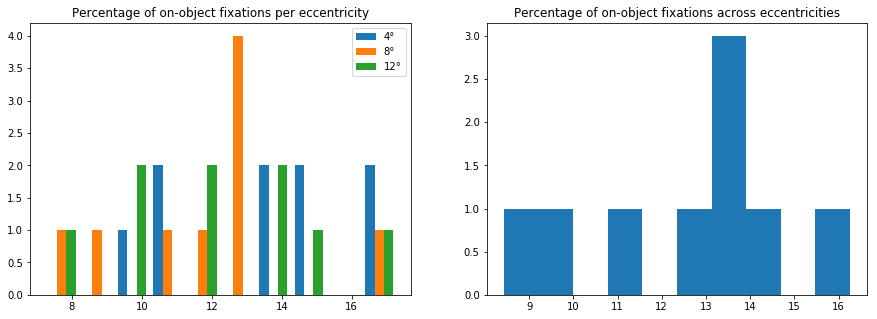

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(percent_on_object)
plt.title('Percentage of on-object fixations per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_on_object)
plt.title('Percentage of on-object fixations across eccentricities')

**Time between last fixation and response**

In [59]:
''''
reaction_latency = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        timediff = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Efix']==[]:
                #time between end of last and start of first fixation
                fixtime = (eye_data[trial]['events']['Efix'][-1][1]-eye_data[trial]['events']['Efix'][0][0])/1000
                #print(fixtime)
                #print('RT',behv_data['RT'][trial])
                reactiontime = behv_data['RT'][trial]
                time = reactiontime-fixtime
                timediff.append(time)
    
        reaction_latency[sub][e]=np.mean(timediff) 

In [68]:
reaction_latency = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        timediff = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Efix']==[]:
                #time between eyelink recorded response and end of fixation
                time = eye_data[trial]['events']['msg'][-2][0]-eye_data[trial]['events']['Efix'][-1][1]
                timediff.append(time)
    
        reaction_latency[sub][e]=np.mean(timediff) 

In [69]:
print('Time between last fixation and response per subject and eccentricity')
print(reaction_latency)

Time between last reaction and response per subject and eccentricity
[[ 264.26666667  235.25316456  247.57740586]
 [ 335.69166667  377.425       392.49166667]
 [ 396.825       366.7375      369.17083333]
 [  94.53617021   92.97424893   86.05485232]
 [ 262.7625      279.19583333  277.74895397]
 [ 300.09166667  278.57563025  274.94166667]
 [ 222.72268908  238.64705882  243.05042017]
 [ 296.38888889  308.09583333  303.29583333]
 [ 293.15899582  246.35833333  231.3125    ]]


## Correlation

**Eccentricity 4°**

In [70]:
print('Correlation of critical distance and RT:')
print(pearsonr(crit_distance[:,0],rt_ecc[:,0]))#gives pearson r and two-tailed p-value
print(spearmanr(crit_distance[:,0],rt_ecc[:,0]))

Correlation of critical distance and RT:
(-0.56853787036108372, 0.11019103963516626)
SpearmanrResult(correlation=-0.45573271518764996, pvalue=0.21763669160144453)


In [71]:
print('Correlation of critical distance and number of fixations:')
print(pearsonr(crit_distance[:,0],ecc_fix[:,0]))
print(spearmanr(crit_distance[:,0],ecc_fix[:,0]))

Correlation of critical distance and number of fixations:
(-0.76638173884832306, 0.016007428171455049)
SpearmanrResult(correlation=-0.68359907278147491, pvalue=0.042330058001984854)


In [72]:
print('Correlation of critical distance and start latency:')
print(pearsonr(crit_distance[:,0],ecc_lat[:,0]))
print(spearmanr(crit_distance[:,0],ecc_lat[:,0]))

Correlation of critical distance and start latency:
(0.1705657800857987, 0.6608404635189089)
SpearmanrResult(correlation=0.10127393670836665, pvalue=0.79544166547953088)


In [90]:
print('Correlation of critical distance and saccadic latency:')
print(pearsonr(crit_distance[:,0],ecc_sacclat[:,0]))
print(spearmanr(crit_distance[:,0],ecc_sacclat[:,0]))

Correlation of critical distance and saccadic latency:
(-0.086665282609903735, 0.82454826051666452)
SpearmanrResult(correlation=0.10127393670836665, pvalue=0.79544166547953088)


In [73]:
print('Correlation of critical distance and on-object fixation:')
print(pearsonr(crit_distance[:,0],percent_on_object[:,0]))
print(spearmanr(crit_distance[:,0],percent_on_object[:,0]))

Correlation of critical distance and on-object fixation:
(-0.2085387565017647, 0.59026464878514873)
SpearmanrResult(correlation=-0.30382181012509996, pvalue=0.42671436663749296)


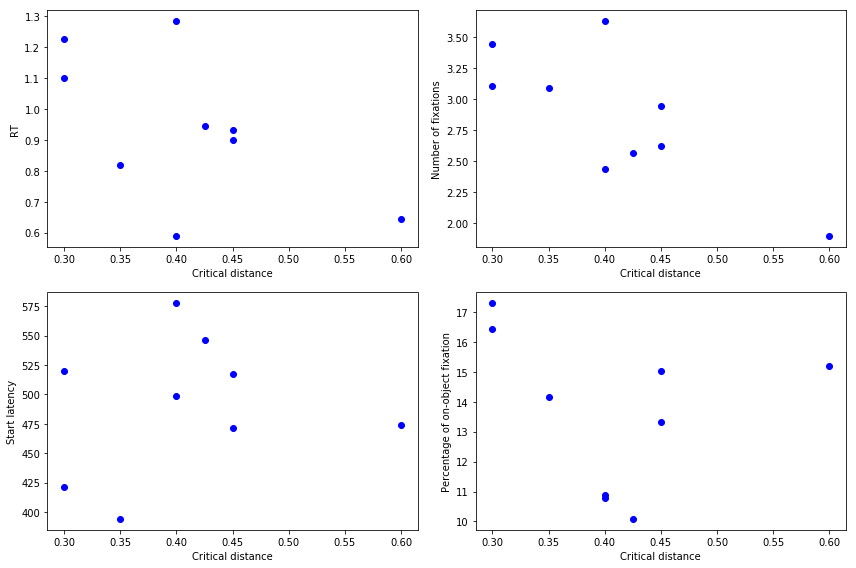

In [74]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(crit_distance[:,0],rt_ecc[:,0], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('RT')

plt.subplot(2,2,2)
plt.plot(crit_distance[:,0],ecc_fix[:,0], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Number of fixations')

plt.subplot(2,2,3)
plt.plot(crit_distance[:,0],ecc_lat[:,0], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Start latency')

plt.subplot(2,2,4)
plt.plot(crit_distance[:,0],percent_on_object[:,0], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Percentage of on-object fixation')

plt.tight_layout()

**Eccentricity 8°**

In [75]:
print('Correlation of critical distance and RT:')
print(pearsonr(crit_distance[:,1],rt_ecc[:,1]))
print(spearmanr(crit_distance[:,1],rt_ecc[:,1]))

Correlation of critical distance and RT:
(0.22957722445133905, 0.55236664057647444)
SpearmanrResult(correlation=0.083682740875572315, pvalue=0.83051463533149972)


In [76]:
print('Correlation of critical distance and number of fixations:')
print(pearsonr(crit_distance[:,1],ecc_fix[:,1]))
print(spearmanr(crit_distance[:,1],ecc_fix[:,1]))

Correlation of critical distance and number of fixations:
(0.088809317761340212, 0.82026404369852657)
SpearmanrResult(correlation=-0.20083857810137351, pvalue=0.60435935452149492)


In [77]:
print('Correlation of critical distance and start latency:')
print(pearsonr(crit_distance[:,1],ecc_lat[:,1]))
print(spearmanr(crit_distance[:,1],ecc_lat[:,1]))

Correlation of critical distance and start latency:
(0.40559749611567336, 0.27878001668019303)
SpearmanrResult(correlation=0.29288959306450307, pvalue=0.44435469568522479)


In [78]:
print('Correlation of critical distance and on-object fixation:')
print(pearsonr(crit_distance[:,1],percent_on_object[:,1]))
print(spearmanr(crit_distance[:,1],percent_on_object[:,1]))

Correlation of critical distance and on-object fixation:
(0.24247193295034525, 0.52960546169032385)
SpearmanrResult(correlation=0.0, pvalue=1.0)


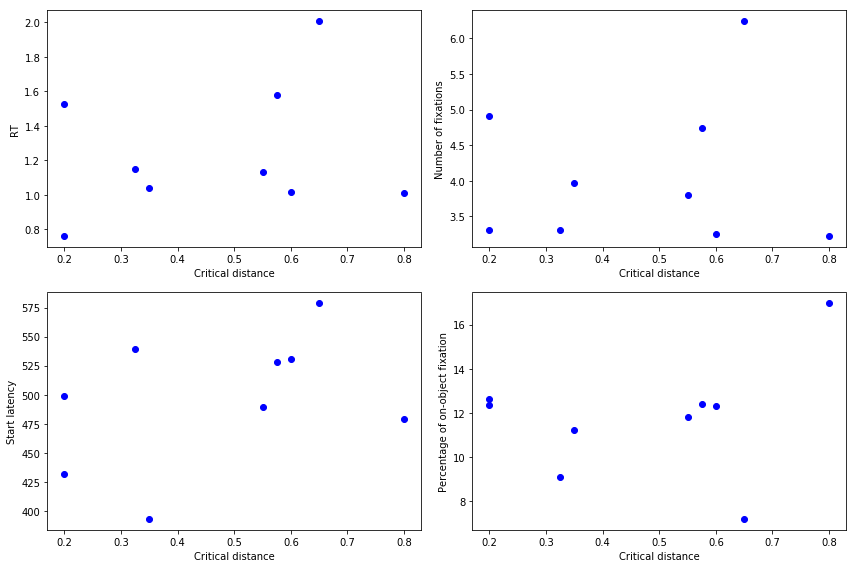

In [79]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(crit_distance[:,1],rt_ecc[:,1], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('RT')

plt.subplot(2,2,2)
plt.plot(crit_distance[:,1],ecc_fix[:,1], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Number of fixations')

plt.subplot(2,2,3)
plt.plot(crit_distance[:,1],ecc_lat[:,1], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Start latency')

plt.subplot(2,2,4)
plt.plot(crit_distance[:,1],percent_on_object[:,1], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Percentage of on-object fixation')

plt.tight_layout()

**Eccentricity 12°**

In [80]:
print('Correlation of critical distance and RT:')
print(pearsonr(crit_distance[:,2],rt_ecc[:,2]))
print(spearmanr(crit_distance[:,2],rt_ecc[:,2]))

Correlation of critical distance and RT:
(0.27079508703649385, 0.48094911526637574)
SpearmanrResult(correlation=0.19578900207451219, pvalue=0.61366443933688153)


In [81]:
print('Correlation of critical distance and number of fixations:')
print(pearsonr(crit_distance[:,2],ecc_fix[:,2]))
print(spearmanr(crit_distance[:,2],ecc_fix[:,2]))

Correlation of critical distance and number of fixations:
(0.30094177489767693, 0.43133091757880182)
SpearmanrResult(correlation=0.2553769592276246, pvalue=0.50720145997146804)


In [82]:
print('Correlation of critical distance and start latency:')
print(pearsonr(crit_distance[:,2],ecc_lat[:,2]))
print(spearmanr(crit_distance[:,2],ecc_lat[:,2]))

Correlation of critical distance and start latency:
(0.095227757621075007, 0.80746364796130765)
SpearmanrResult(correlation=0.017025130615174973, pvalue=0.96532506523309214)


In [83]:
print('Correlation of critical distance and on-object fixation:')
print(pearsonr(crit_distance[:,2],percent_on_object[:,2]))
print(spearmanr(crit_distance[:,2],percent_on_object[:,2]))

Correlation of critical distance and on-object fixation:
(0.28603529612944489, 0.45557433737781095)
SpearmanrResult(correlation=0.37455287353384942, pvalue=0.32063580253680479)


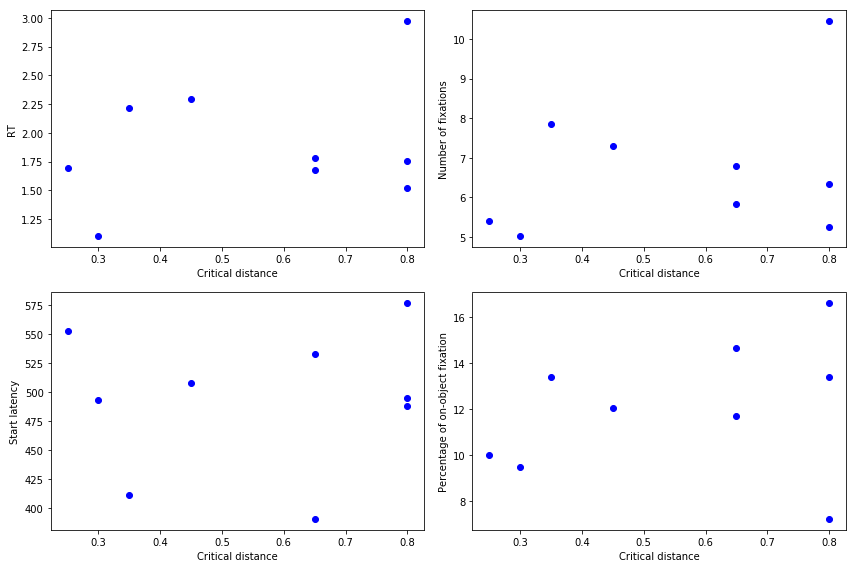

In [84]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(crit_distance[:,2],rt_ecc[:,2], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('RT')

plt.subplot(2,2,2)
plt.plot(crit_distance[:,2],ecc_fix[:,2], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Number of fixations')

plt.subplot(2,2,3)
plt.plot(crit_distance[:,2],ecc_lat[:,2], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Start latency')

plt.subplot(2,2,4)
plt.plot(crit_distance[:,2],percent_on_object[:,2], 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Percentage of on-object fixation')

plt.tight_layout()

**Subject Means**


In [85]:
print('Correlation of critical distance and RT:')
print(pearsonr(crit_dist_mean,rt_mean))
print(spearmanr(crit_dist_mean,rt_mean))

Correlation of critical distance and RT:
(0.14175460547157739, 0.71601197867488819)
SpearmanrResult(correlation=0.083682740875572315, pvalue=0.83051463533149972)


In [86]:
print('Correlation of critical distance and mean number of fixations:')
print(pearsonr(crit_dist_mean,mean_fix))
print(spearmanr(crit_dist_mean,mean_fix))

Correlation of critical distance and mean number of fixations:
(0.047375264479766907, 0.90366823250242001)
SpearmanrResult(correlation=-0.050209644525343378, pvalue=0.89792839547032333)


In [87]:
print('Correlation of critical distance and start latency:')
print(pearsonr(crit_dist_mean,mean_lat))
print(spearmanr(crit_dist_mean,mean_lat))

Correlation of critical distance and start latency:
(0.3661983089732489, 0.33240516718703361)
SpearmanrResult(correlation=0.25941649671427414, pvalue=0.5002682642509535)


In [88]:
print('Correlation of critical distance and on-object fixation:')
print(pearsonr(crit_dist_mean,mean_on_object))
print(spearmanr(crit_dist_mean,mean_on_object))

Correlation of critical distance and on-object fixation:
(0.29847870742119831, 0.43529658945065436)
SpearmanrResult(correlation=0.15899720766358738, pvalue=0.68283981571505259)


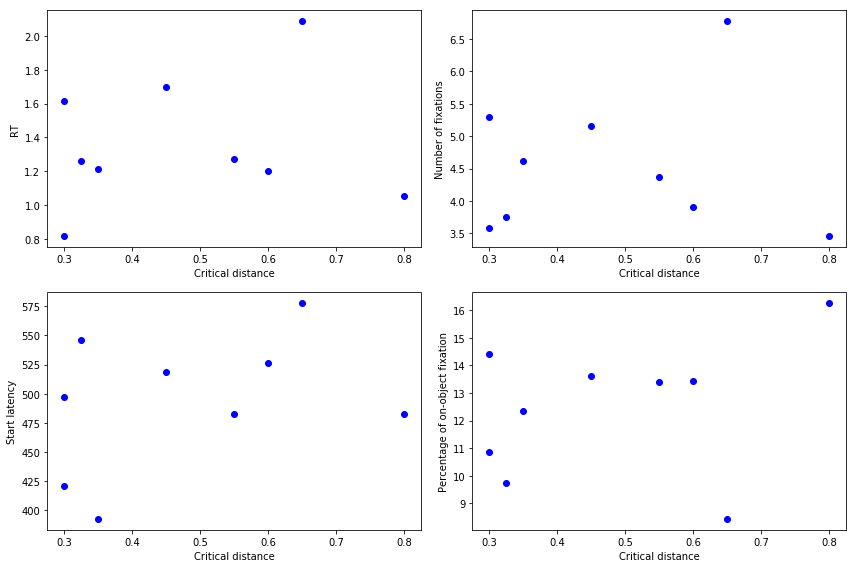

In [89]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(crit_dist_mean,rt_mean, 'bo')
plt.xlabel('Critical distance')
plt.ylabel('RT')

plt.subplot(2,2,2)
plt.plot(crit_dist_mean,mean_fix, 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Number of fixations')

plt.subplot(2,2,3)
plt.plot(crit_dist_mean,mean_lat, 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Start latency')

plt.subplot(2,2,4)
plt.plot(crit_dist_mean,mean_on_object, 'bo')
plt.xlabel('Critical distance')
plt.ylabel('Percentage of on-object fixation')

plt.tight_layout()